In [40]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from keras import backend as K
import gc

tf.get_logger().setLevel('ERROR')

# Getting Data

In [73]:
ttf = pd.read_csv('/kaggle/input/dataset/ttf.csv', encoding='utf-16')
brent = pd.read_csv('/kaggle/input/dataset/brent.csv', encoding='utf-16')
coal = pd.read_csv('/kaggle/input/dataset/coal.csv', encoding='utf-16')
eu50 = pd.read_csv('/kaggle/input/dataset/eu50.csv', encoding='utf-16')
eurusd = pd.read_csv('/kaggle/input/dataset/eurusd.csv', encoding='utf-16')
gasoline = pd.read_csv('/kaggle/input/dataset/gasoline.csv', encoding='utf-16')
natural_gas = pd.read_csv('/kaggle/input/dataset/natural_gas.csv', encoding='utf-16')

business_confidence = pd.read_csv('/kaggle/input/dataset/Business_Confidence.csv')
industrial_production = pd.read_csv('/kaggle/input/dataset/industrial_production.csv')
manufacturing_production = pd.read_csv('/kaggle/input/dataset/manufacturing_production.csv')
industrial_sentiment = pd.read_csv('/kaggle/input/dataset/industrial_sentiment.csv')
mining_production = pd.read_csv('/kaggle/input/dataset/mining_production.csv')
services_sentiment = pd.read_csv('/kaggle/input/dataset/services_sentiment.csv')
consumer_confidence = pd.read_csv('/kaggle/input/dataset/Consumer_Confidence.csv')
retail_sales = pd.read_csv('/kaggle/input/dataset/retail_sales.csv')
optimism_index = pd.read_csv('/kaggle/input/dataset/optimism_index.csv')
inflation_rate = pd.read_csv('/kaggle/input/dataset/inflation_rate.csv')
energy_inflation = pd.read_csv('/kaggle/input/dataset/energy_inflation.csv')
balance_of_trade = pd.read_csv('/kaggle/input/dataset/balance_of_trade.csv')
current_account = pd.read_csv('/kaggle/input/dataset/current_account.csv')
current_account_goods = pd.read_csv('/kaggle/input/dataset/current_account_goods.csv')
current_account_services = pd.read_csv('/kaggle/input/dataset/current_account_services.csv')
exports = pd.read_csv('/kaggle/input/dataset/exports.csv')
imports = pd.read_csv('/kaggle/input/dataset/imports.csv')
money_supply_m1 = pd.read_csv('/kaggle/input/dataset/money_supply_m1.csv')
unemployment_rate = pd.read_csv('/kaggle/input/dataset/unemployment_rate.csv')

In [74]:
def process_market_data(df, column_name):
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df = df.groupby([df['Date'].dt.year, df['Date'].dt.month], as_index=False).last()
    df['Date'] = df['Date'].dt.strftime('%Y-%m')
    df = df[['Date', 'Close']]
    df.rename(columns={'Close': column_name}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

def process_business_data(df, value_column_name):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Date'] = df['DateTime'].dt.strftime('%Y-%m')
    df = df[['Date', 'Value']].copy()
    df.rename(columns={'Value': value_column_name}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [75]:
ttf = process_market_data(ttf, 'ttf')
brent = process_market_data(brent, 'brent')
coal = process_market_data(coal, 'coal')
eu50 = process_market_data(eu50, 'eu50')
eurusd = process_market_data(eurusd, 'eurusd')
gasoline = process_market_data(gasoline, 'gasoline')
natural_gas = process_market_data(natural_gas, 'natural_gas')

business_confidence = process_business_data(business_confidence, 'business_confidence')
industrial_production = process_business_data(industrial_production, 'industrial_production')
manufacturing_production = process_business_data(manufacturing_production, 'manufacturing_production')
industrial_sentiment = process_business_data(industrial_sentiment, 'industrial_sentiment')
mining_production = process_business_data(mining_production, 'mining_production')
services_sentiment = process_business_data(services_sentiment, 'services_sentiment')
consumer_confidence = process_business_data(consumer_confidence, 'consumer_confidence')
retail_sales = process_business_data(retail_sales, 'retail_sales')
optimism_index = process_business_data(optimism_index, 'optimism_index')
inflation_rate = process_business_data(inflation_rate, 'inflation_rate')
energy_inflation = process_business_data(energy_inflation, 'energy_inflation')
balance_of_trade = process_business_data(balance_of_trade, 'balance_of_trade')
current_account = process_business_data(current_account, 'current_account')
current_account_goods = process_business_data(current_account_goods, 'current_account_goods')
current_account_services = process_business_data(current_account_services, 'current_account_services')
exports = process_business_data(exports, 'exports')
imports = process_business_data(imports, 'imports')
money_supply_m1 = process_business_data(money_supply_m1, 'money_supply_m1')
unemployment_rate = process_business_data(unemployment_rate, 'unemployment_rate')

/tmp/ipykernel_72/1330222753.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [76]:
df_raw = ttf.copy()
df_raw = df_raw.join(brent, how='left')
df_raw = df_raw.join(coal, how='left')
df_raw = df_raw.join(eu50, how='left')
df_raw = df_raw.join(eurusd, how='left')
df_raw = df_raw.join(gasoline, how='left')
df_raw = df_raw.join(natural_gas, how='left')
df_raw = df_raw.join(business_confidence, how='left')
df_raw = df_raw.join(industrial_production, how='left')
df_raw = df_raw.join(manufacturing_production, how='left')
df_raw = df_raw.join(industrial_sentiment, how='left')
df_raw = df_raw.join(mining_production, how='left')
df_raw = df_raw.join(services_sentiment, how='left')
df_raw = df_raw.join(consumer_confidence, how='left')
df_raw = df_raw.join(retail_sales, how='left')
df_raw = df_raw.join(optimism_index, how='left')
df_raw = df_raw.join(inflation_rate, how='left')
df_raw = df_raw.join(energy_inflation, how='left')
df_raw = df_raw.join(balance_of_trade, how='left')
df_raw = df_raw.join(current_account, how='left')
df_raw = df_raw.join(current_account_goods, how='left')
df_raw = df_raw.join(current_account_services, how='left')
df_raw = df_raw.join(exports, how='left')
df_raw = df_raw.join(imports, how='left')
df_raw = df_raw.join(money_supply_m1, how='left')
df_raw = df_raw.join(unemployment_rate, how='left')

df_raw = df_raw.dropna()

In [77]:
df_raw.head(5)

,ttf,brent,coal,eu50,eurusd,gasoline,natural_gas,business_confidence,industrial_production,manufacturing_production,...,inflation_rate,energy_inflation,balance_of_trade,current_account,current_account_goods,current_account_services,exports,imports,money_supply_m1,unemployment_rate
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-01,12.50,76.89,96.90,2772.70,1.3560,2.1556,4.679,-1.18,8.0,8.6,...,1.6,7.2,1410.6,1.23,6.43,2.1747,135694.6,134284.1,4581075.0,10.3
2010-04-01,11.53,84.01,96.35,2978.50,1.3581,2.3237,4.086,-0.72,8.9,9.1,...,1.6,9.1,-1102.7,-1.97,3.28,4.1505,121676.9,122779.5,4632909.0,10.4
2010-05-01,14.10,88.94,107.50,2816.50,1.3192,2.4351,4.000,-0.51,8.9,8.9,...,1.7,9.2,-5472.3,-17.11,-1.44,4.6660,122304.9,127777.2,4649612.0,10.3
2010-06-01,16.47,72.71,99.05,2606.58,1.2225,1.9825,4.248,-0.34,8.5,9.8,...,1.5,6.2,434.0,-1.19,5.80,4.3097,138840.1,138406.1,4673534.0,10.3
2010-07-01,20.65,72.34,98.15,2518.65,1.2517,1.9976,4.854,-0.05,8.0,8.7,...,1.7,8.1,4502.7,5.66,8.35,5.1507,138412.9,133910.1,4680426.0,10.3


In [78]:
df = df_raw.copy()

columns_to_pct_diff = ['ttf', 'brent', 'coal', 'eu50', 'eurusd', 'gasoline', 'natural_gas', 'money_supply_m1', 'exports', 'imports']
df[columns_to_pct_diff] = df[columns_to_pct_diff].pct_change()

columns_to_first_diff = ['business_confidence', 'industrial_production', 'manufacturing_production', 'industrial_sentiment', 'mining_production', 'services_sentiment', 'consumer_confidence', 'optimism_index',
                        'inflation_rate', 'energy_inflation', 'unemployment_rate', 'balance_of_trade', 'current_account', 'current_account_goods']
for column in columns_to_first_diff:
    df[column] = np.diff(df[column], prepend=np.nan)

df = df.dropna()

In [79]:
df.head(5)

,ttf,brent,coal,eu50,eurusd,gasoline,natural_gas,business_confidence,industrial_production,manufacturing_production,...,inflation_rate,energy_inflation,balance_of_trade,current_account,current_account_goods,current_account_services,exports,imports,money_supply_m1,unemployment_rate
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-01,-0.077600,0.092600,-0.005676,0.074224,0.001549,0.077983,-0.126736,0.46,0.9,0.5,...,0.0,1.9,-2513.3,-3.20,-3.15,4.1505,-0.103303,-0.085674,0.011315,0.1
2010-05-01,0.222897,0.058683,0.115724,-0.054390,-0.028643,0.047941,-0.021047,0.21,0.0,-0.2,...,0.1,0.1,-4369.6,-15.14,-4.72,4.6660,0.005161,0.040705,0.003605,-0.1
2010-06-01,0.168085,-0.182483,-0.078605,-0.074532,-0.073302,-0.185865,0.062000,0.17,-0.4,0.9,...,-0.2,-3.0,5906.3,15.92,7.24,4.3097,0.135197,0.083183,0.005145,0.0
2010-07-01,0.253795,-0.005089,-0.009086,-0.033734,0.023885,0.007617,0.142655,0.29,-0.5,-1.1,...,0.2,1.9,4068.7,6.85,2.55,5.1507,-0.003077,-0.032484,0.001475,0.0
2010-08-01,-0.075545,0.117224,-0.033622,0.120509,0.052968,0.085553,-0.031520,0.19,1.0,0.9,...,-0.1,-2.0,-10849.7,-10.14,-10.64,4.4341,-0.123189,-0.046308,0.002788,-0.1


# Data Exploration

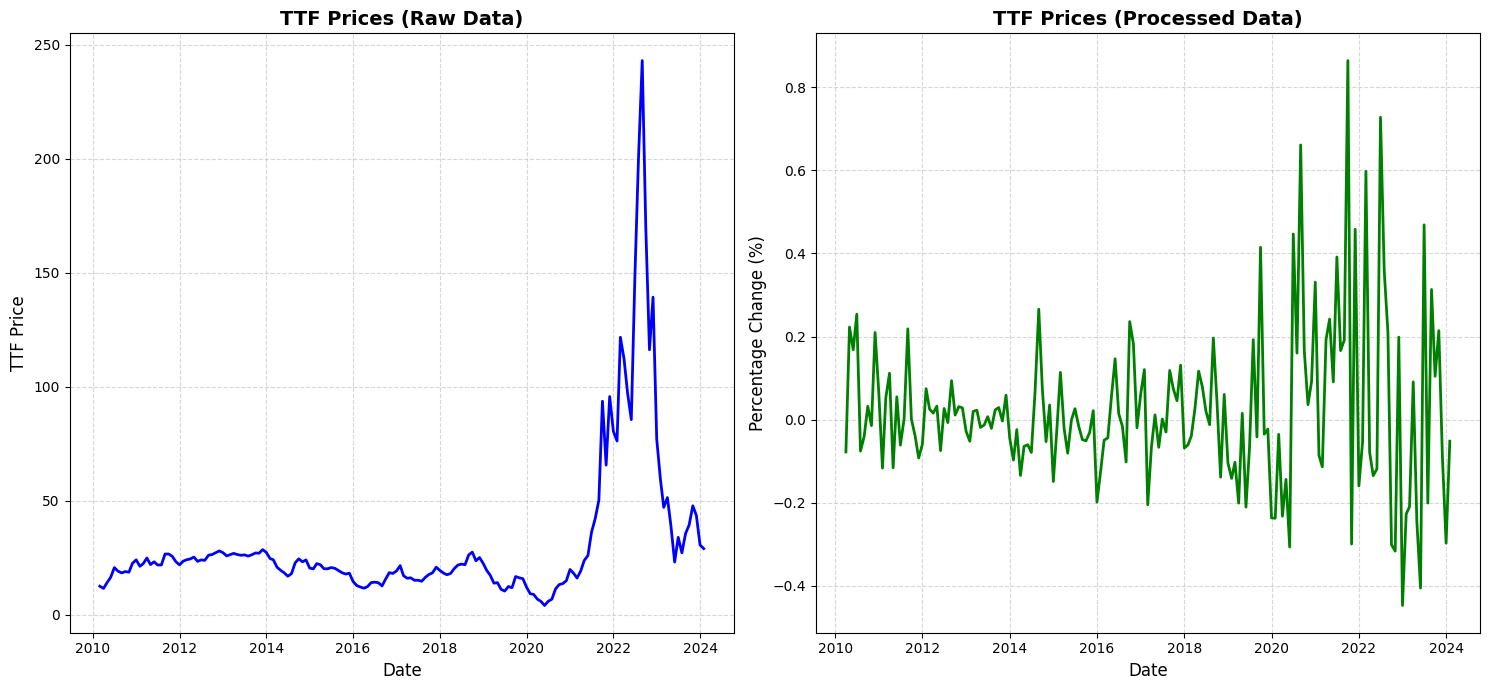

In [9]:
# Creating a more polished version of the charts
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plotting df_raw 'ttf' with improved aesthetics
axes[0].plot(df_raw.index, df_raw.ttf, color='blue', linewidth=2, linestyle='-', markersize=5)
axes[0].set_title('TTF Prices (Raw Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('TTF Price', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plotting df 'ttf' with improved aesthetics
axes[1].plot(df.index, df.ttf, color='green', linewidth=2, linestyle='-', markersize=5)
axes[1].set_title('TTF Prices (Processed Data)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Percentage Change (%)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Overall layout adjustments
plt.tight_layout()
plt.show()

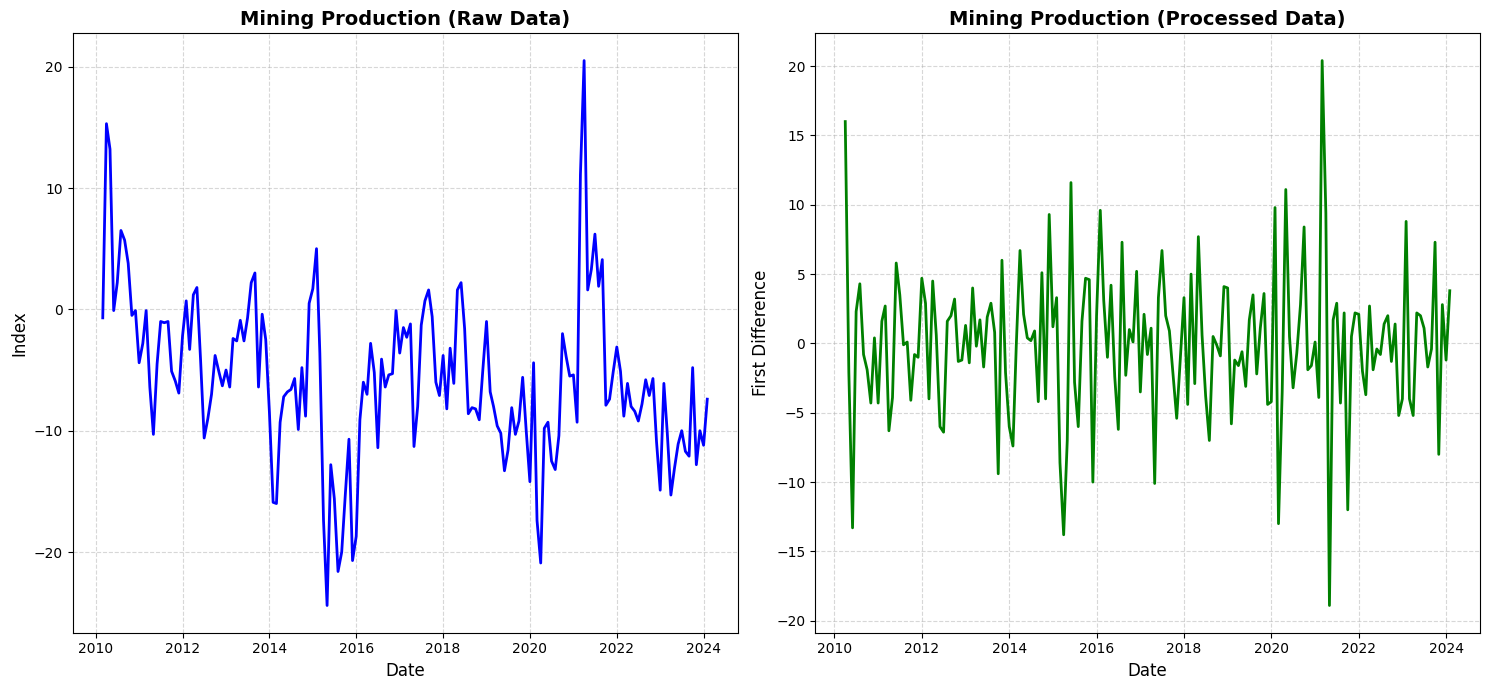

In [10]:
# Creating a more polished version of the charts
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plotting df_raw 'ttf' with improved aesthetics
axes[0].plot(df_raw.index, df_raw.mining_production, color='blue', linewidth=2, linestyle='-', markersize=5)
axes[0].set_title('Mining Production (Raw Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Index', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plotting df 'ttf' with improved aesthetics
axes[1].plot(df.index, df.mining_production, color='green', linewidth=2, linestyle='-', markersize=5)
axes[1].set_title('Mining Production (Processed Data)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('First Difference', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Overall layout adjustments
plt.tight_layout()
plt.show()

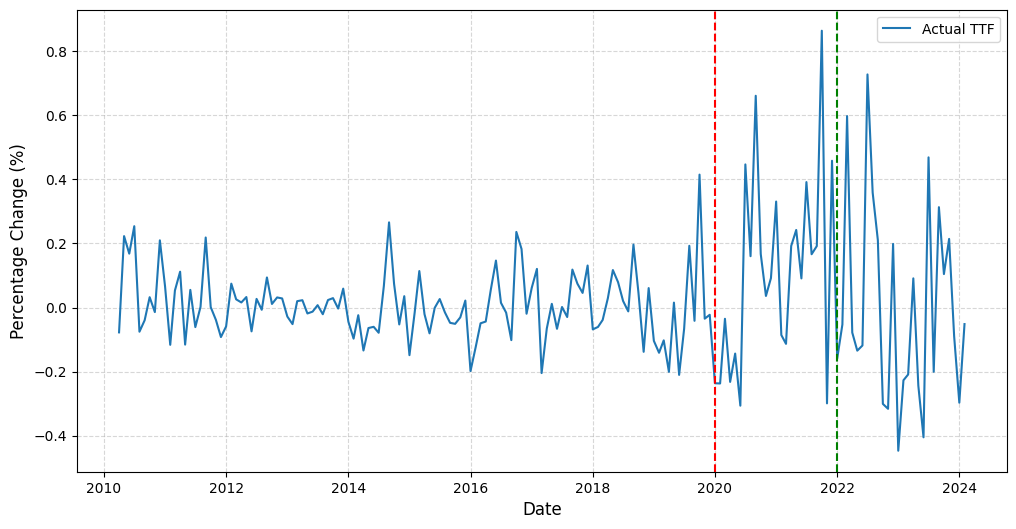

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df.ttf, label='Actual TTF')
plt.legend()    
plt.axvline(pd.Timestamp('2020-01-01'), color='r', linestyle='--', label='01.01.2020')
plt.axvline(pd.Timestamp('2022-01-01'), color='g', linestyle='--', label='01.01.2022')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

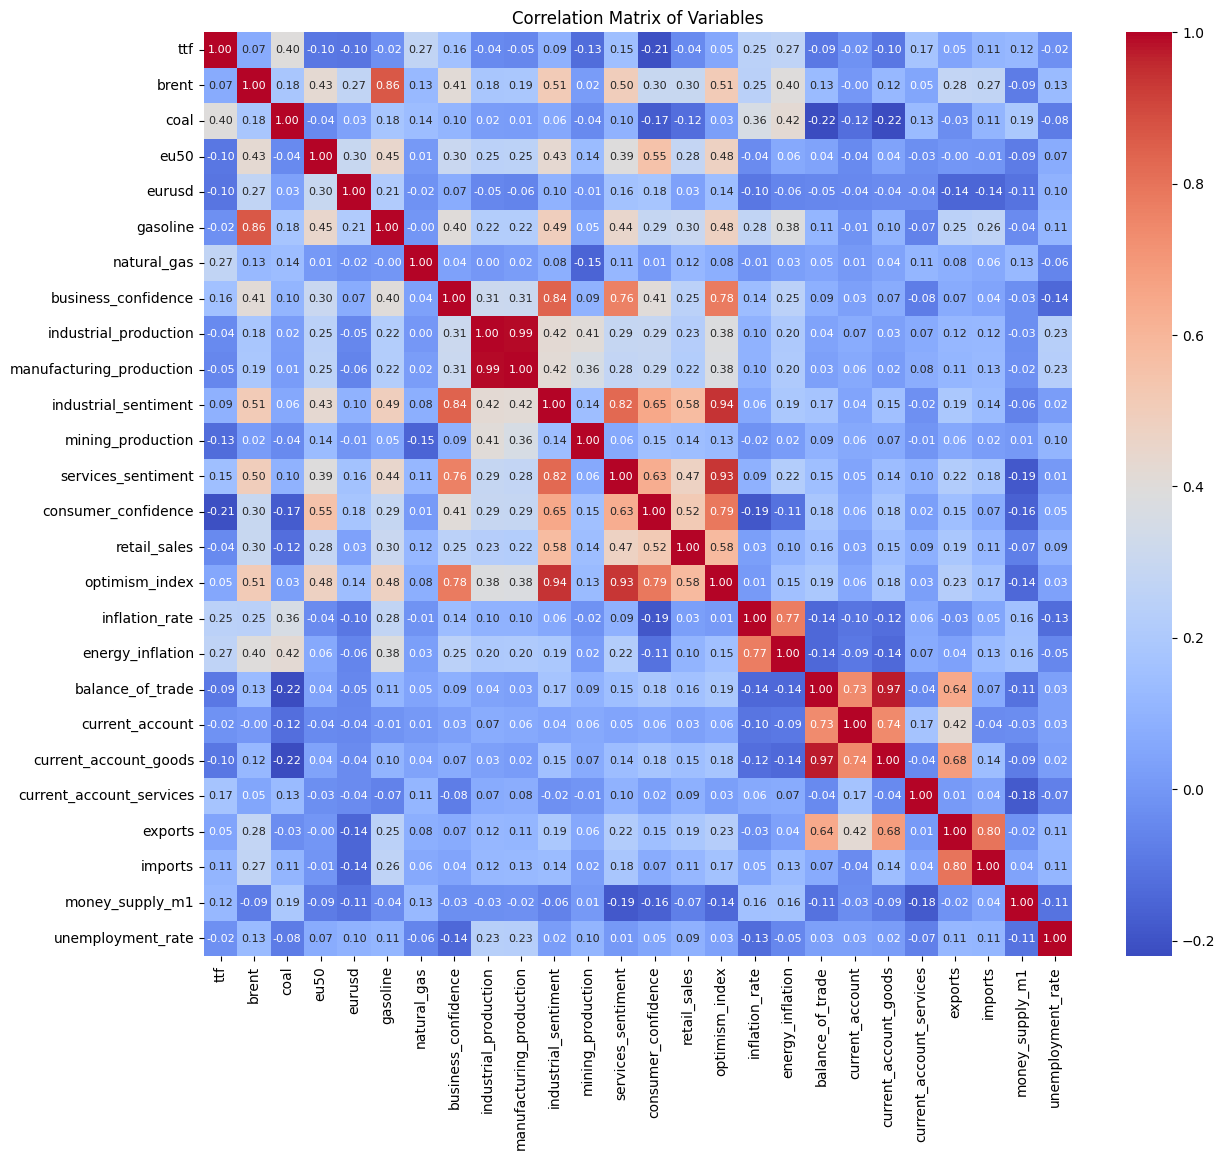

In [12]:
# Calculating the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Variables')
plt.show()

# Functions

## 1. Random walk

In [13]:
def runrw(ind, df, variable, horizon, window):
    df_window = df.iloc[ind:ind+window]
    last_value = df_window[variable].values[-1]
    
    # Create forecasts for each horizon
    forecasts = np.full(horizon, last_value)
    
    # Calculate accumulated forecast for h-month horizon
    if horizon > 1:
        accumulated_forecast = np.cumsum(forecasts)[:horizon] - last_value * (horizon - 1)
        forecast = accumulated_forecast[-1]
    else:
        forecast = last_value
    
    return {'forecast': forecast}

## 2. Autoregressive model

In [14]:
def runar(ind, df, variable, horizon, window):
    # Ensure the date index has a frequency
    if df.index.freq is None:
        df = df.asfreq(pd.infer_freq(df.index))
    
    # Define the window of data for the model
    df_window = df.iloc[ind:ind+window]
    
    # Fit the AR(1) model
    model = AutoReg(df_window[variable], lags=1).fit()
    
    # Forecast the future values
    forecast_start = df.index[ind+window]
    forecast_end = df.index[min(ind+window+horizon-1, len(df)-1)]
    forecast = model.predict(start=forecast_start, end=forecast_end, dynamic=False)
    
    return {'forecast': forecast.iloc[-1]}

## 3. Lasso regression

In [15]:
def runlasso(ind, df, variable, horizon, window, alpha=1.0):
    # Prepare the data
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit Lasso model with cross-validation to find the best alpha
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=200000).fit(X_train, y_train)
    best_alpha = lasso_cv.alpha_
    
    lasso = Lasso(alpha=best_alpha, random_state=42, max_iter=200000)
    lasso.fit(X_train, y_train)
    
    # Make forecast
    forecast = lasso.predict(X_test)
    
    # Collect model outputs
    coeflvl = lasso.coef_
    coefpar = coeflvl * np.std(X_train, axis=0)
    outputs = {
        'coeflvl': coeflvl,
        'coefpar': coefpar,
        'lambda': best_alpha
    }
    
    return {'forecast': forecast[horizon-1], 'outputs': outputs}

## 4. Adaptive lasso

In [16]:
def runadalasso(ind, df, variable, horizon, window, alpha=1.0):
    # Prepare the data
    df_window = df.iloc[ind:ind + window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]

    X_test = df.iloc[ind + window:ind + window + horizon].drop(columns=[variable])

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit Lasso model with cross-validation to find the best alpha
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=200000).fit(X_train, y_train)
    best_alpha = lasso_cv.alpha_

    # Compute adaptive weights
    coef = np.abs(lasso_cv.coef_)
    penalty = np.power(coef + 1 / np.sqrt(len(y_train)), -1)

    # Fit adaptive Lasso model with weighted features
    lasso = Lasso(alpha=best_alpha, random_state=42, max_iter=40000)
    # Apply penalty to each feature in X_train
    lasso.fit(X_train * penalty, y_train)

    # Make forecast
    forecast = lasso.predict(X_test * penalty)

    # Collect model outputs
    coeflvl = lasso.coef_
    coefpar = coeflvl * np.std(X_train, axis=0)
    outputs = {
        'coeflvl': coeflvl,
        'coefpar': coefpar,
        'lambda': best_alpha
    }

    return {'forecast': forecast[horizon - 1], 'outputs': outputs}

## 5. Ridge regression

In [17]:
def runridge(ind, df, variable, horizon, window, alphas=np.logspace(-6, 6, 13)):
    # Prepare the data
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit Ridge model with cross-validation to find the best alpha
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train, y_train)
    best_alpha = ridge_cv.alpha_
    
    # Make forecast
    forecast = ridge_cv.predict(X_test)
    
    # Collect model outputs
    coeflvl = ridge_cv.coef_
    coefpar = coeflvl * np.std(X_train, axis=0)
    outputs = {
        'coeflvl': coeflvl,
        'coefpar': coefpar,
        'lambda': best_alpha
    }
    
    return {'forecast': forecast[horizon-1], 'outputs': outputs}

## 6. Elastic Net Regression

In [18]:
def run_elasticnet(ind, df, variable, horizon, window, l1_ratio=[0.1, 0.5, 0.9], max_iter=100000):
    # Prepare the data
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit ElasticNet model with cross-validation to find the best alpha and l1_ratio
    elasticnet_cv = ElasticNetCV(l1_ratio=l1_ratio, cv=5, random_state=42, max_iter=max_iter).fit(X_train, y_train)
    
    # Make forecast
    forecast = elasticnet_cv.predict(X_test)
    
    # Collect model outputs
    coeflvl = elasticnet_cv.coef_
    coefpar = coeflvl * np.std(X_train, axis=0)
    best_alpha = elasticnet_cv.alpha_
    best_l1_ratio = elasticnet_cv.l1_ratio_
    outputs = {
        'coeflvl': coeflvl,
        'coefpar': coefpar,
        'alpha': best_alpha,
        'l1_ratio': best_l1_ratio
    }
    
    return {'forecast': forecast[horizon-1], 'outputs': outputs}

## 7. Random Forest

In [19]:
def runrf(ind, df, variable, horizon, window):
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    forecast = model.predict(X_test)
    
    return {'forecast': forecast[horizon-1]}

## 8. Bagging Regressor

In [20]:
def runbagging(ind, df, variable, horizon, window):
    # Prepare the data
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Fit Bagging model
    model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make forecast
    forecast = model.predict(X_test)
    
    # Collect model outputs
    feature_importances = np.mean([
        tree.feature_importances_ for tree in model.estimators_
    ], axis=0)
    nselect = (feature_importances > 0).astype(int)
    
    outputs = {'nselect': nselect}
    
    return {'forecast': forecast[horizon-1], 'outputs': outputs}

## 9. SVM

In [21]:
# Define the SVM model function
def runsvm(ind, df, variable, horizon, window):
    # Select the window of data
    df_window = df.iloc[ind:ind+window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    # Select the test data
    X_test = df.iloc[ind+window:ind+window+horizon].drop(columns=[variable])
    
    # Handle missing values using imputer
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Define the SVM model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can adjust the kernel, C, and epsilon parameters as needed
    model.fit(X_train, y_train)
    
    # Make forecast
    forecast = model.predict(X_test)
    
    # Return the forecast at the required horizon
    return {'forecast': forecast[horizon-1]}

## 10. LSTM

In [41]:
# Define the LSTM model function
def runlstm(ind, df, variable, horizon, window):
    # Prepare the window of data
    df_window = df.iloc[ind:ind + window]
    X_train = df_window.drop(columns=[variable])
    y_train = df_window[variable]
    
    # Prepare the test data
    X_test = df.iloc[ind + window:ind + window + horizon].drop(columns=[variable])
    
    # Handle missing values using imputer
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Scale the data to be between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Reshape data for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # Define the LSTM model with Input layer
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=20, verbose=0, batch_size=32)
    
    # Make predictions
    forecast = model.predict(X_test, verbose=0)
    
    # Clear the model from memory
    del model
    gc.collect()  # Explicitly trigger garbage collection
    tf.keras.backend.clear_session()  # Clear the session
    tf.compat.v1.reset_default_graph() 
    
    # Return the forecast at the required horizon
    return {'forecast': forecast[horizon - 1][0]}

# Methods

In [23]:
# Define the rolling window function
def rolling_window(model_function, df, nwindows, horizon, variable):
    forecasts = []
    for start in range(len(df) - nwindows - horizon + 1):
        result = model_function(start, df, variable, horizon, nwindows)
        forecasts.append(result['forecast'])
    return {'forecast': np.array(forecasts)}

In [24]:
# Define the expanding window function
def expanding_window(model_function, df, initial_window, horizon, variable):
    forecasts = []
    for end in range(initial_window, len(df) - horizon + 1):
        result = model_function(0, df, variable, horizon, end)
        forecasts.append(result['forecast'])
    return {'forecast': np.array(forecasts)}

In [25]:
def run_forecast_and_evaluation(df, model_function, nwindows, horizon, variable, use_expanding_window = False, plot = False):
    
    if use_expanding_window == False:
        model = rolling_window(model_function, df, nwindows, horizon, variable)
    elif use_expanding_window == True:
        model = expanding_window(model_function, df, nwindows, horizon, variable)
    
    forecasts = model['forecast']
    
    max_len = len(forecasts)
    # Plot the results
    if plot == True:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index[-max_len:], df[variable].iloc[-max_len:], label='Actual TTF')
        plt.plot(df.index[-max_len:], forecasts, label=f'Forecast horizon {horizon}')
        plt.legend()
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Percentage Change (%)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    # Save the forecasts
    forecasts_df = pd.DataFrame(forecasts, index=df.index[-max_len:], columns=[f'horizon_{horizon}'])

    # Evaluation for the specified horizon
    yout = df[variable].iloc[-max_len:].values

    # Calculate the RMSE for the forecasts
    rmse = round(np.sqrt(np.nanmean((forecasts - yout)**2)), 4)

    # Calculate the MAE for the forecasts
    mae = round(np.nanmean(np.abs(forecasts - yout)), 4)

    # Calculate the MAD for the forecasts
    mad = round(np.nanmean(np.abs(forecasts - np.nanmean(forecasts))), 4)
    
    # Calculate the R-squared for the forecasts
    ss_res = np.sum((yout - forecasts)**2)
    ss_tot = np.sum((yout - np.mean(yout))**2)
    r_squared = round(1 - (ss_res / ss_tot), 4)
    
    return forecasts_df, rmse, mae, mad, r_squared

In [26]:
def create_lagged_features(df, target_variable, lags):
    df = df.copy()
    lagged_data = {}

    columns = df.columns
    for column in columns:
        for lag in range(1, lags + 1):
            lagged_data[f'{column}_lag_{lag}'] = df[column].shift(lag)
    
    # Create a DataFrame from the lagged data
    lagged_df = pd.DataFrame(lagged_data)
    
    # Combine the original target variable and the lagged features
    combined_df = pd.concat([df[target_variable], lagged_df], axis=1)
    
    # Drop rows with NaN values
    combined_df = combined_df.dropna()
    
    return combined_df

# Examples

In [27]:
nwindows = 70
horizon = 1

## 1. Random Walk

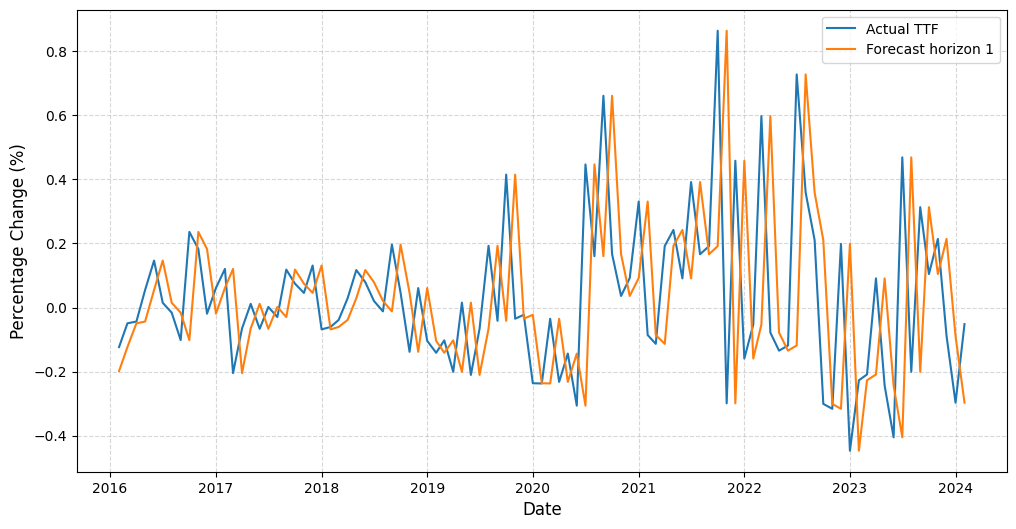

RMSE for horizon 1: 0.3302
MAE for horizon 1: 0.234
MAD for horizon 1: 0.1803
R Squared for horizon 1: -0.9362


In [28]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(df, runrw, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 2. Autoregressive model

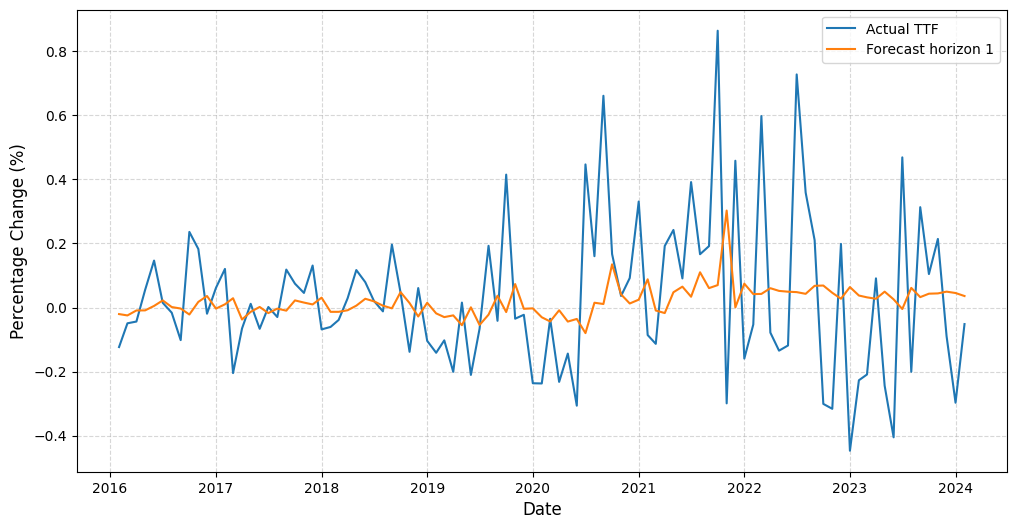

RMSE for horizon 1: 0.2443
MAE for horizon 1: 0.1781
MAD for horizon 1: 0.0328
R Squared for horizon 1: -0.0604


In [29]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(df, runar, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 3. Lasso regression

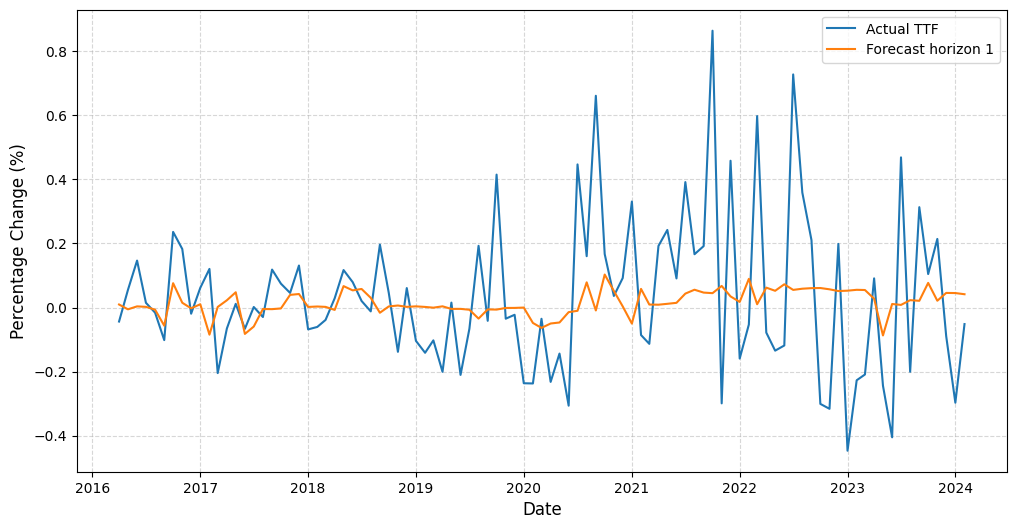

RMSE for horizon 1: 0.2395
MAE for horizon 1: 0.1757
MAD for horizon 1: 0.0311
R Squared for horizon 1: -0.0034


In [30]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 2), runlasso, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 4. Adaptive lasso

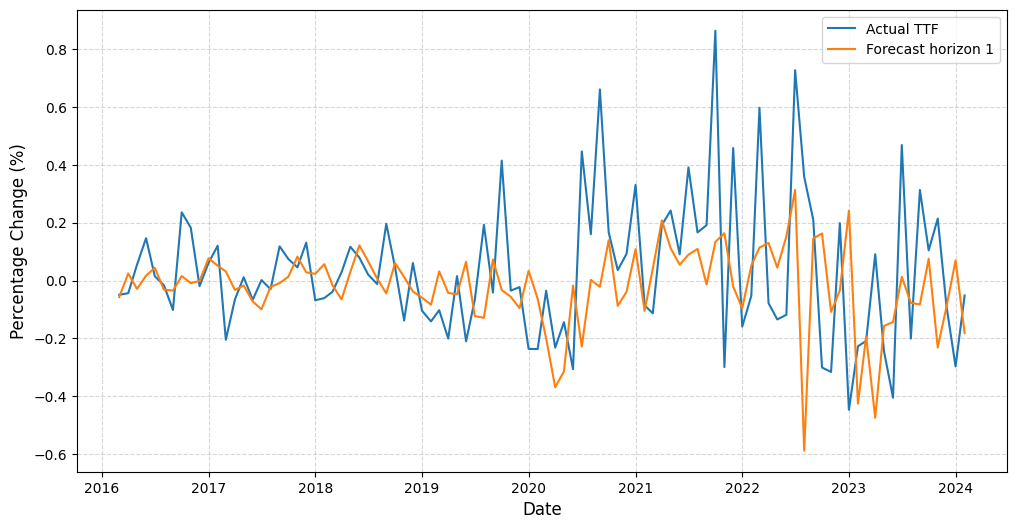

RMSE for horizon 1: 0.2638
MAE for horizon 1: 0.184
MAD for horizon 1: 0.0963
R Squared for horizon 1: -0.2289


In [31]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 1), runadalasso, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 5. Ridge regression

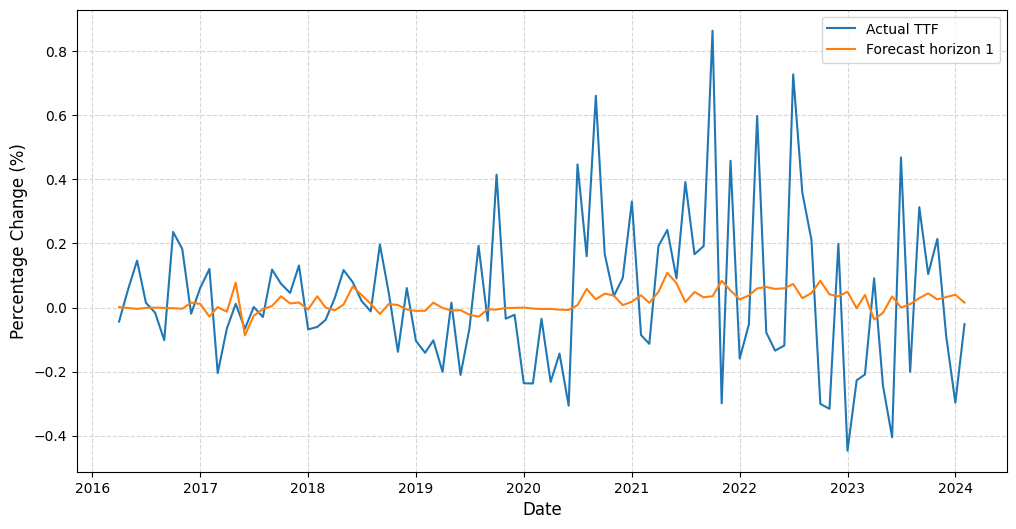

RMSE for horizon 1: 0.2375
MAE for horizon 1: 0.1759
MAD for horizon 1: 0.025
R Squared for horizon 1: 0.0129


In [32]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 2), runridge, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 6. Elastic Net Regression

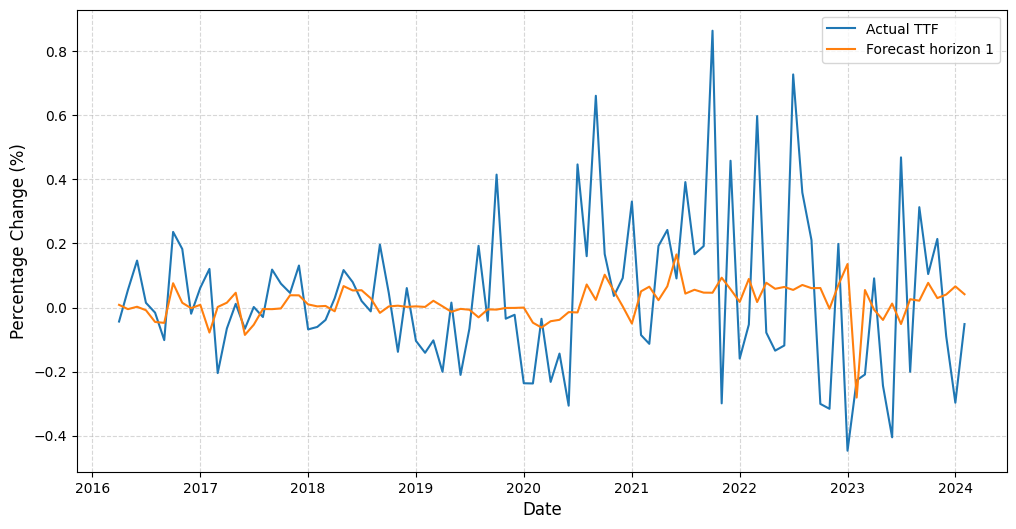

RMSE for horizon 1: 0.2396
MAE for horizon 1: 0.1753
MAD for horizon 1: 0.038
R Squared for horizon 1: -0.0046


In [33]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 2), run_elasticnet, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 7. Random Forest

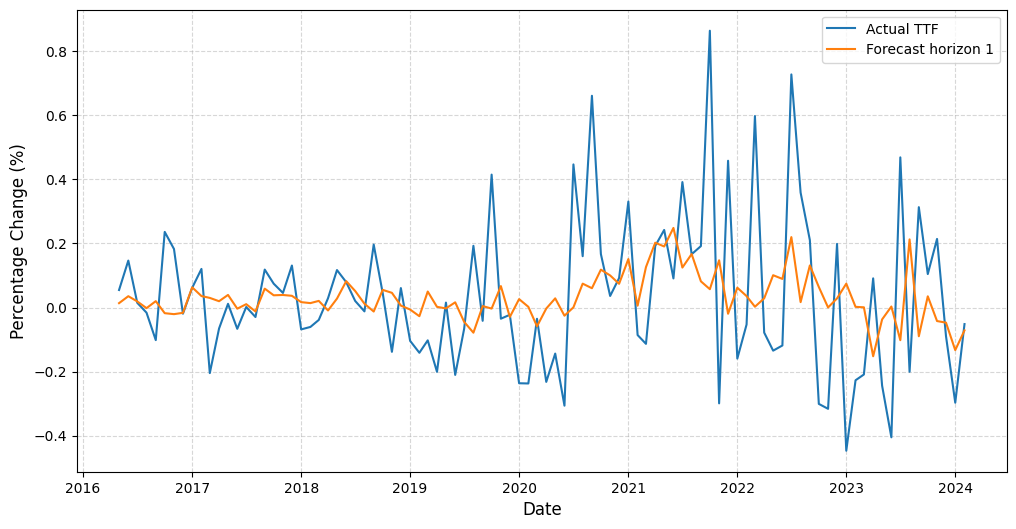

RMSE for horizon 1: 0.2405
MAE for horizon 1: 0.1735
MAD for horizon 1: 0.0515
R Squared for horizon 1: -0.0028


In [34]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 3), runrf, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 8. Bagging Regressor

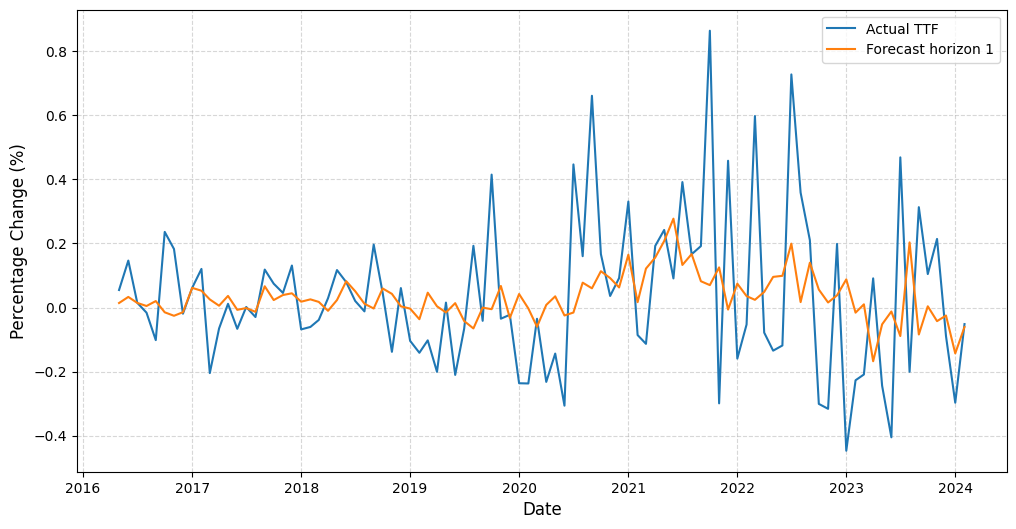

RMSE for horizon 1: 0.2393
MAE for horizon 1: 0.1736
MAD for horizon 1: 0.0521
R Squared for horizon 1: 0.0073


In [35]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 3), runbagging, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 9. SVM

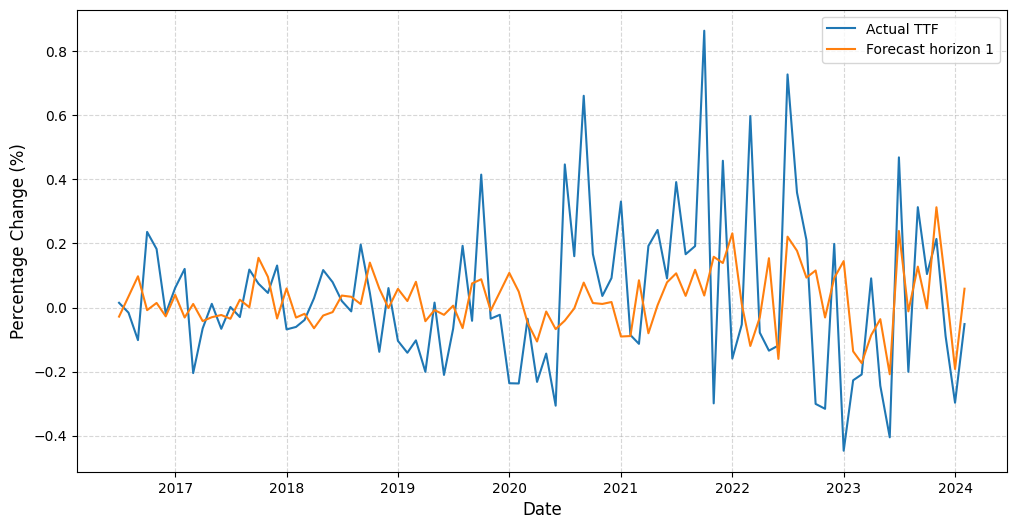

RMSE for horizon 1: 0.2357
MAE for horizon 1: 0.1747
MAD for horizon 1: 0.0717
R Squared for horizon 1: 0.0552


In [36]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 5), runsvm, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

## 10. LSTM

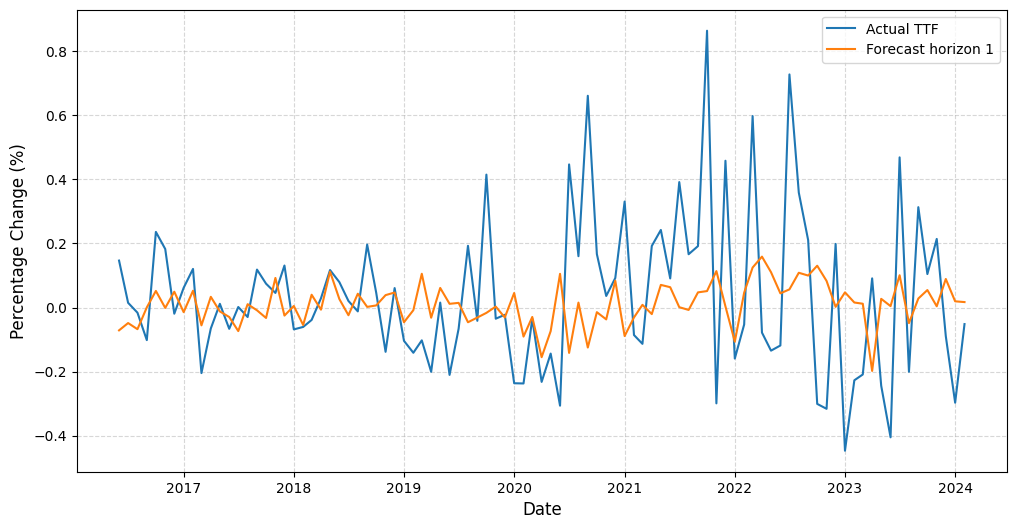

RMSE for horizon 1: 0.2525
MAE for horizon 1: 0.1865
MAD for horizon 1: 0.05000000074505806
R Squared for horizon 1: -0.0936


In [42]:
forecasts_df, rmse, mae, mad, r_squared = run_forecast_and_evaluation(create_lagged_features(df, 'ttf', 4), runlstm, nwindows, horizon, "ttf", plot = True)
print(f"RMSE for horizon {horizon}: {rmse}")
print(f"MAE for horizon {horizon}: {mae}")
print(f"MAD for horizon {horizon}: {mad}")
print(f"R Squared for horizon {horizon}: {r_squared}")

# Calculations

## Entire Dataset with Rolling Window

### Random Walk

In [50]:
rmse_results_rw = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rw = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rw = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rw = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrw, nwindows, horizon, "ttf")
        rmse_results_rw.at[lag, horizon] = rmse
        mae_results_rw.at[lag, horizon] = mae
        mad_results_rw.at[lag, horizon] = mad
        r_squared_results_rw.at[lag, horizon] = r_squared

### Autoregression

In [51]:
rmse_results_ar = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_ar = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_ar = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_ar = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runar, nwindows, horizon, "ttf")
        rmse_results_ar.at[lag, horizon] = rmse
        mae_results_ar.at[lag, horizon] = mae
        mad_results_ar.at[lag, horizon] = mad
        r_squared_results_ar.at[lag, horizon] = r_squared

### LASSO

In [52]:
rmse_results_lasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlasso, nwindows, horizon, "ttf")
        rmse_results_lasso.at[lag, horizon] = rmse
        mae_results_lasso.at[lag, horizon] = mae
        mad_results_lasso.at[lag, horizon] = mad
        r_squared_results_lasso.at[lag, horizon] = r_squared

### adaLASSO

In [53]:
rmse_results_adalasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_adalasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_adalasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_adalasso = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runadalasso, nwindows, horizon, "ttf")
        rmse_results_adalasso.at[lag, horizon] = rmse
        mae_results_adalasso.at[lag, horizon] = mae
        mad_results_adalasso.at[lag, horizon] = mad
        r_squared_results_adalasso.at[lag, horizon] = r_squared

### Ridge Regression

In [54]:
rmse_results_rr = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rr = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rr = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rr = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runridge, nwindows, horizon, "ttf")
        rmse_results_rr.at[lag, horizon] = rmse
        mae_results_rr.at[lag, horizon] = mae
        mad_results_rr.at[lag, horizon] = mad
        r_squared_results_rr.at[lag, horizon] = r_squared

### ElasticNet

In [55]:
rmse_results_en = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_en = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_en = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_en = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, run_elasticnet, nwindows, horizon, "ttf")
        rmse_results_en.at[lag, horizon] = rmse
        mae_results_en.at[lag, horizon] = mae
        mad_results_en.at[lag, horizon] = mad
        r_squared_results_en.at[lag, horizon] = r_squared

### Random Forest

In [56]:
rmse_results_rf = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rf = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rf = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rf = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrf, nwindows, horizon, "ttf")
        rmse_results_rf.at[lag, horizon] = rmse
        mae_results_rf.at[lag, horizon] = mae
        mad_results_rf.at[lag, horizon] = mad
        r_squared_results_rf.at[lag, horizon] = r_squared

### Bagging

In [57]:
rmse_results_bag = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_bag = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_bag = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_bag = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runbagging, nwindows, horizon, "ttf")
        rmse_results_bag.at[lag, horizon] = rmse
        mae_results_bag.at[lag, horizon] = mae
        mad_results_bag.at[lag, horizon] = mad
        r_squared_results_bag.at[lag, horizon] = r_squared

### SVR

In [58]:
rmse_results_svm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_svm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_svm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_svm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runsvm, nwindows, horizon, "ttf")
        rmse_results_svm.at[lag, horizon] = rmse
        mae_results_svm.at[lag, horizon] = mae
        mad_results_svm.at[lag, horizon] = mad
        r_squared_results_svm.at[lag, horizon] = r_squared

### LSTM

In [59]:
rmse_results_lstm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lstm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lstm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lstm = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlstm, nwindows, horizon, "ttf")
        rmse_results_lstm.at[lag, horizon] = rmse
        mae_results_lstm.at[lag, horizon] = mae
        mad_results_lstm.at[lag, horizon] = mad
        r_squared_results_lstm.at[lag, horizon] = r_squared

## Entire Dataset with Expanding Window

### Random Walk

In [60]:
rmse_results_rw_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rw_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rw_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rw_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrw, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_rw_exp.at[lag, horizon] = rmse
        mae_results_rw_exp.at[lag, horizon] = mae
        mad_results_rw_exp.at[lag, horizon] = mad
        r_squared_results_rw_exp.at[lag, horizon] = r_squared

### Autoregression

In [61]:
rmse_results_ar_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_ar_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_ar_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_ar_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runar, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_ar_exp.at[lag, horizon] = rmse
        mae_results_ar_exp.at[lag, horizon] = mae
        mad_results_ar_exp.at[lag, horizon] = mad
        r_squared_results_ar_exp.at[lag, horizon] = r_squared

### LASSO

In [62]:
rmse_results_lasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlasso, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_lasso_exp.at[lag, horizon] = rmse
        mae_results_lasso_exp.at[lag, horizon] = mae
        mad_results_lasso_exp.at[lag, horizon] = mad
        r_squared_results_lasso_exp.at[lag, horizon] = r_squared

### adaLASSO

In [64]:
rmse_results_adalasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_adalasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_adalasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_adalasso_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runadalasso, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_adalasso_exp.at[lag, horizon] = rmse
        mae_results_adalasso_exp.at[lag, horizon] = mae
        mad_results_adalasso_exp.at[lag, horizon] = mad
        r_squared_results_adalasso_exp.at[lag, horizon] = r_squared

### Ridge Regression

In [65]:
rmse_results_rr_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rr_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rr_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rr_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runridge, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_rr_exp.at[lag, horizon] = rmse
        mae_results_rr_exp.at[lag, horizon] = mae
        mad_results_rr_exp.at[lag, horizon] = mad
        r_squared_results_rr_exp.at[lag, horizon] = r_squared

### ElasticNet

In [66]:
rmse_results_en_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_en_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_en_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_en_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, run_elasticnet, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_en_exp.at[lag, horizon] = rmse
        mae_results_en_exp.at[lag, horizon] = mae
        mad_results_en_exp.at[lag, horizon] = mad
        r_squared_results_en_exp.at[lag, horizon] = r_squared

### Random Forest

In [67]:
rmse_results_rf_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rf_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rf_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rf_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrf, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_rf_exp.at[lag, horizon] = rmse
        mae_results_rf_exp.at[lag, horizon] = mae
        mad_results_rf_exp.at[lag, horizon] = mad
        r_squared_results_rf_exp.at[lag, horizon] = r_squared

### Bagging

In [68]:
rmse_results_bag_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_bag_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_bag_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_bag_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runbagging, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_bag_exp.at[lag, horizon] = rmse
        mae_results_bag_exp.at[lag, horizon] = mae
        mad_results_bag_exp.at[lag, horizon] = mad
        r_squared_results_bag_exp.at[lag, horizon] = r_squared

### SVR

In [69]:
rmse_results_svm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_svm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_svm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_svm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runsvm, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_svm_exp.at[lag, horizon] = rmse
        mae_results_svm_exp.at[lag, horizon] = mae
        mad_results_svm_exp.at[lag, horizon] = mad
        r_squared_results_svm_exp.at[lag, horizon] = r_squared

### LSTM

In [70]:
rmse_results_lstm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lstm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lstm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lstm_exp = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlstm, nwindows, horizon, "ttf", use_expanding_window = True)
        rmse_results_lstm_exp.at[lag, horizon] = rmse
        mae_results_lstm_exp.at[lag, horizon] = mae
        mad_results_lstm_exp.at[lag, horizon] = mad
        r_squared_results_lstm_exp.at[lag, horizon] = r_squared

# Calculations for the market data

In [80]:
df_market = df[['ttf', 'brent', 'coal', 'eu50', 'eurusd', 'gasoline', 'natural_gas']]

### Random Walk

In [81]:
rmse_results_rw_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rw_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rw_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rw_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrw, nwindows, horizon, "ttf")
        rmse_results_rw_m.at[lag, horizon] = rmse
        mae_results_rw_m.at[lag, horizon] = mae
        mad_results_rw_m.at[lag, horizon] = mad
        r_squared_results_rw_m.at[lag, horizon] = r_squared

### Autoregression

In [83]:
rmse_results_ar_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_ar_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_ar_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_ar_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runar, nwindows, horizon, "ttf")
        rmse_results_ar_m.at[lag, horizon] = rmse
        mae_results_ar_m.at[lag, horizon] = mae
        mad_results_ar_m.at[lag, horizon] = mad
        r_squared_results_ar_m.at[lag, horizon] = r_squared

### LASSO

In [84]:
rmse_results_lasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlasso, nwindows, horizon, "ttf")
        rmse_results_lasso_m.at[lag, horizon] = rmse
        mae_results_lasso_m.at[lag, horizon] = mae
        mad_results_lasso_m.at[lag, horizon] = mad
        r_squared_results_lasso_m.at[lag, horizon] = r_squared

### adaLASSO

In [85]:
rmse_results_adalasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_adalasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_adalasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_adalasso_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runadalasso, nwindows, horizon, "ttf")
        rmse_results_adalasso_m.at[lag, horizon] = rmse
        mae_results_adalasso_m.at[lag, horizon] = mae
        mad_results_adalasso_m.at[lag, horizon] = mad
        r_squared_results_adalasso_m.at[lag, horizon] = r_squared

### Ridge Regression

In [86]:
rmse_results_rr_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rr_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rr_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rr_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runridge, nwindows, horizon, "ttf")
        rmse_results_rr_m.at[lag, horizon] = rmse
        mae_results_rr_m.at[lag, horizon] = mae
        mad_results_rr_m.at[lag, horizon] = mad
        r_squared_results_rr_m.at[lag, horizon] = r_squared

### ElasticNet

In [87]:
rmse_results_en_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_en_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_en_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_en_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, run_elasticnet, nwindows, horizon, "ttf")
        rmse_results_en_m.at[lag, horizon] = rmse
        mae_results_en_m.at[lag, horizon] = mae
        mad_results_en_m.at[lag, horizon] = mad
        r_squared_results_en_m.at[lag, horizon] = r_squared

### Random Forest

In [88]:
rmse_results_rf_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_rf_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_rf_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_rf_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runrf, nwindows, horizon, "ttf")
        rmse_results_rf_m.at[lag, horizon] = rmse
        mae_results_rf_m.at[lag, horizon] = mae
        mad_results_rf_m.at[lag, horizon] = mad
        r_squared_results_rf_m.at[lag, horizon] = r_squared

### Bagging

In [89]:
rmse_results_bag_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_bag_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_bag_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_bag_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runbagging, nwindows, horizon, "ttf")
        rmse_results_bag_m.at[lag, horizon] = rmse
        mae_results_bag_m.at[lag, horizon] = mae
        mad_results_bag_m.at[lag, horizon] = mad
        r_squared_results_bag_m.at[lag, horizon] = r_squared

### SVR

In [90]:
rmse_results_svm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_svm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_svm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_svm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runsvm, nwindows, horizon, "ttf")
        rmse_results_svm_m.at[lag, horizon] = rmse
        mae_results_svm_m.at[lag, horizon] = mae
        mad_results_svm_m.at[lag, horizon] = mad
        r_squared_results_svm_m.at[lag, horizon] = r_squared

### LSTM

In [ ]:
rmse_results_lstm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mae_results_lstm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
mad_results_lstm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))
r_squared_results_lstm_m = pd.DataFrame(index=range(1, 13), columns=range(1, 13))

for lag in range(1, 13):
    lagged_df = create_lagged_features(df_market, 'ttf', lag)
    for horizon in range(1, 13):
        _, rmse, mae, mad, r_squared = run_forecast_and_evaluation(lagged_df, runlstm, nwindows, horizon, "ttf")
        rmse_results_lstm_m.at[lag, horizon] = rmse
        mae_results_lstm_m.at[lag, horizon] = mae
        mad_results_lstm_m.at[lag, horizon] = mad
        r_squared_results_lstm_m.at[lag, horizon] = r_squared

# Visualisation

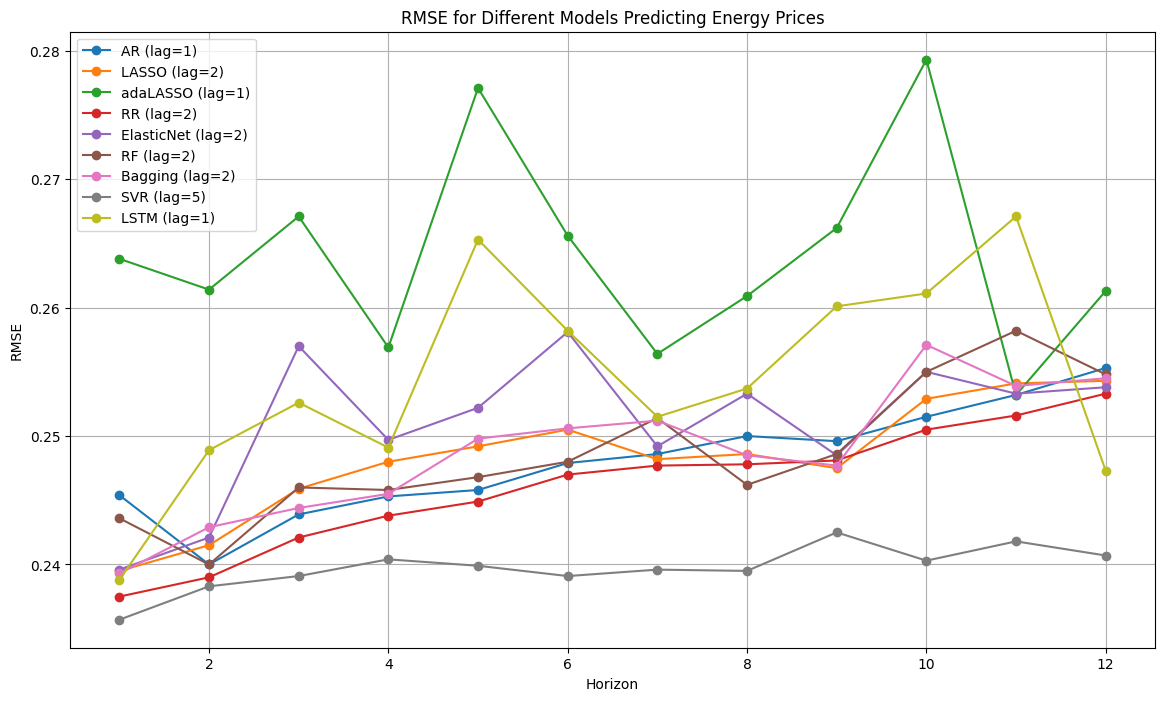

In [43]:
# Plotting the RMSE values for each model
plt.figure(figsize=(14, 8))
for column in df.columns:
    plt.plot(df.index +1 , df[column], marker='o', label=column)

plt.title('RMSE for Different Models Predicting Energy Prices')
plt.xlabel('Horizon')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

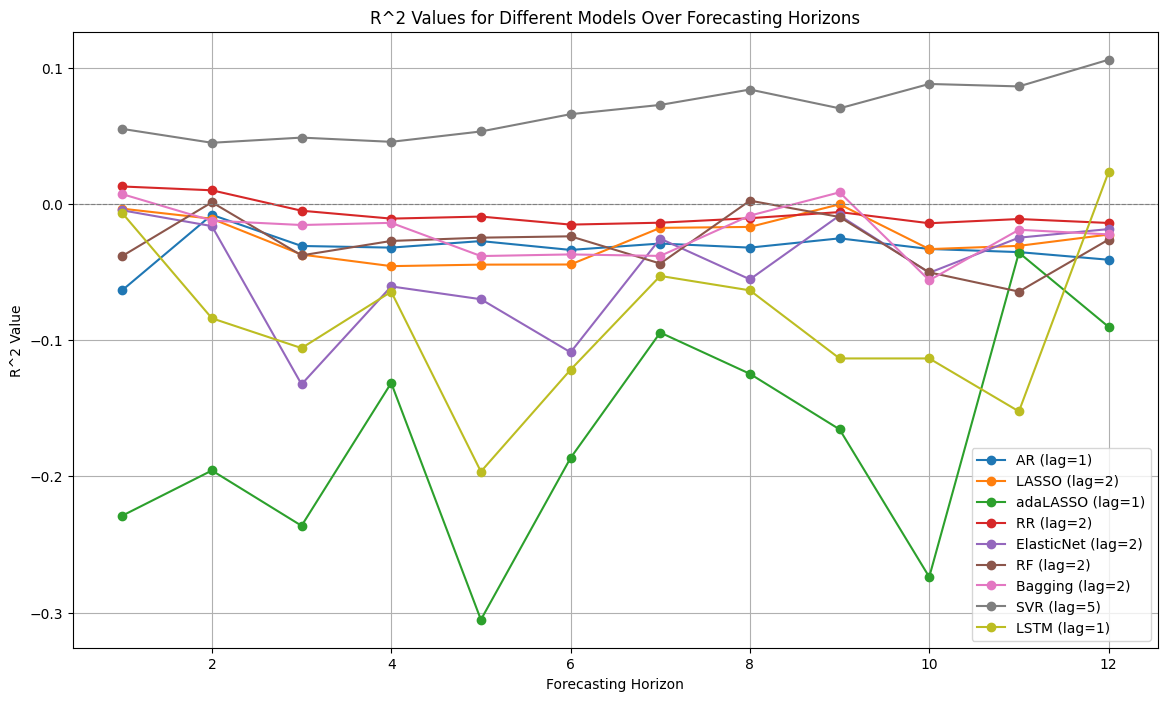

In [44]:
# Plotting the R^2 values for each model
plt.figure(figsize=(14, 8))
for column in r2_df.columns[1:]:
    plt.plot(r2_df['Horizon'], r2_df[column], marker='o', label=column)

plt.title('R^2 Values for Different Models Over Forecasting Horizons')
plt.xlabel('Forecasting Horizon')
plt.ylabel('R^2 Value')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Adding a reference line at R^2 = 0
plt.legend()
plt.grid(True)
plt.show()

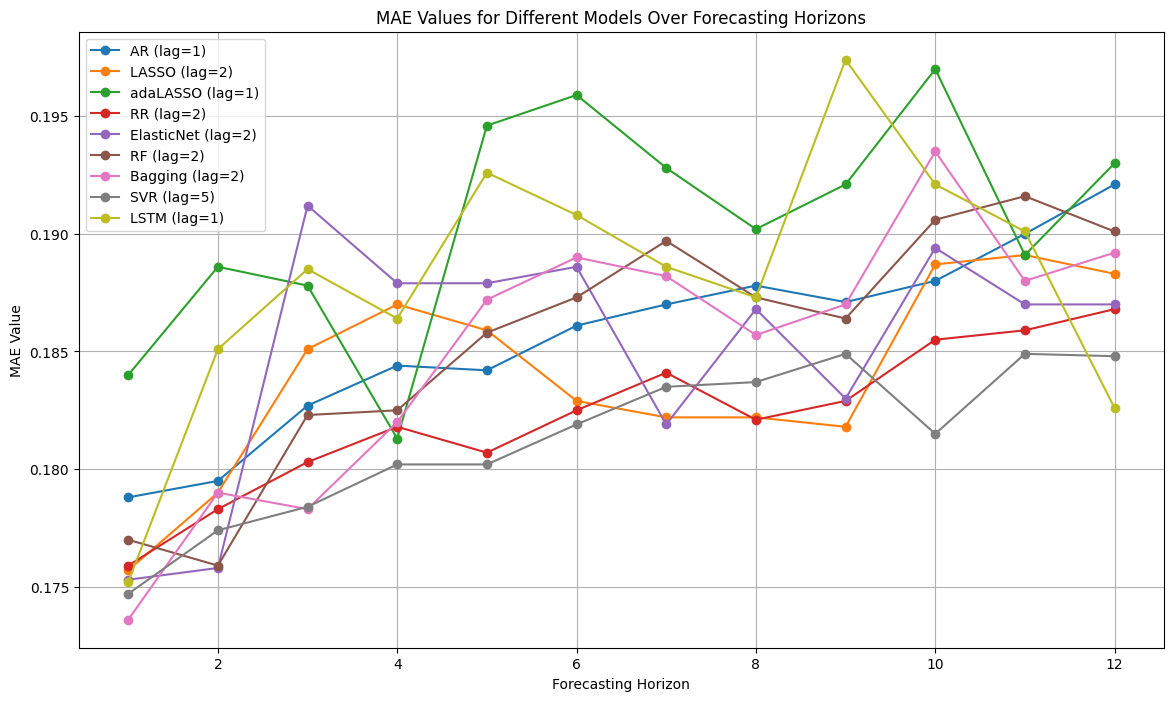

In [45]:
# Plotting the MAE values for each model
plt.figure(figsize=(14, 8))
for column in mae_df.columns[1:]:
    plt.plot(mae_df['Horizon'], mae_df[column], marker='o', label=column)

plt.title('MAE Values for Different Models Over Forecasting Horizons')
plt.xlabel('Forecasting Horizon')
plt.ylabel('MAE Value')
plt.legend()
plt.grid(True)
plt.show()

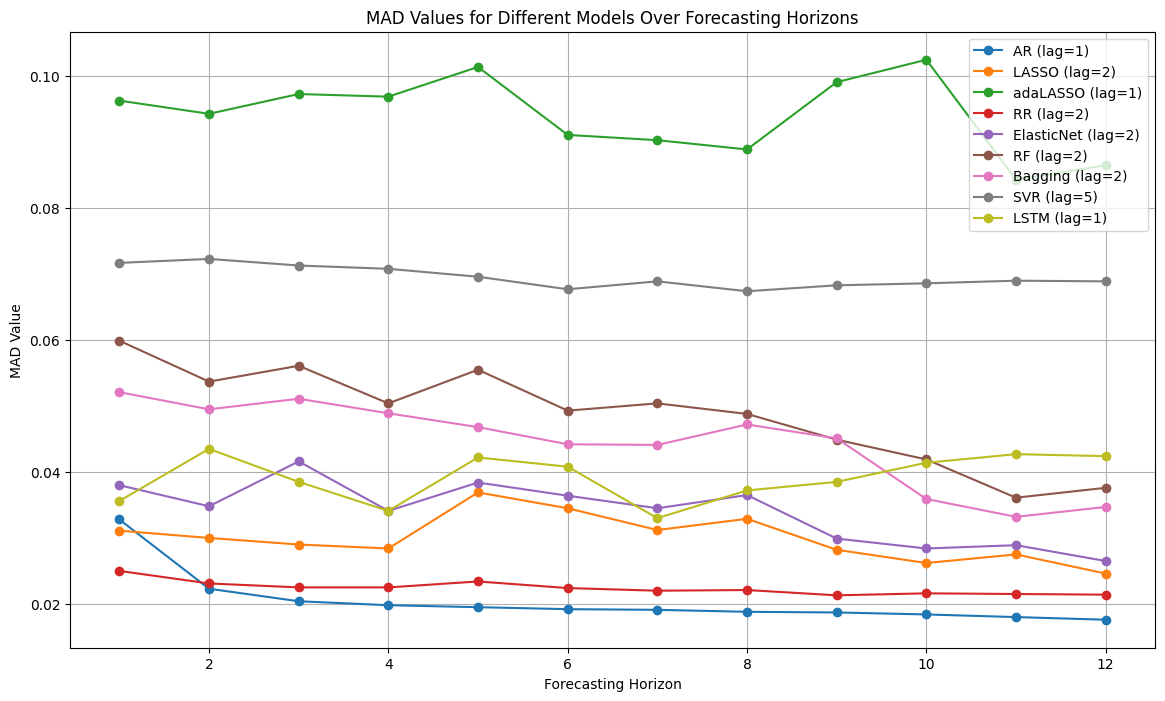

In [46]:
# Plotting the MAD values for each model
plt.figure(figsize=(14, 8))
for column in mad_df.columns[1:]:
    plt.plot(mad_df['Horizon'], mad_df[column], marker='o', label=column)

plt.title('MAD Values for Different Models Over Forecasting Horizons')
plt.xlabel('Forecasting Horizon')
plt.ylabel('MAD Value')
plt.legend()
plt.grid(True)
plt.show()